In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
DATASET_PATH = "/content/drive/MyDrive/tango-cv-assessment-dataset"

In [34]:
import os

In [35]:
image_paths = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.endswith(('.jpg', '.png'))]

In [36]:
print(f"Total images : {len(image_paths)}")

Total images : 25259


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from sklearn.decomposition import PCA
from PIL import Image

In [38]:
# FEATURE EXTRACTION USING PRE-TRAINED RESNET-50 MODEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.to(device).eval()

In [39]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [40]:
def extract_features(image_path):
    try:
        print(image_path)
        image = Image.open(image_path).convert("RGB")
        print(f"step1")
        image = transform(image).unsqueeze(0).to(device)
        print(f"step2")
        with torch.no_grad():
            features = model(image).squeeze().cpu().numpy()
        return features.flatten()
    except Exception as e:
        print(f"Error  {image_path}: {e}")
        return None

In [41]:
features = []
valid_image_paths = []
for i,img_path in enumerate(image_paths[:5000]):
    print(f"Image processing no ==== {i}")
    print(img_path)
    feat = extract_features(img_path)
    if feat is not None:
        features.append(feat)
        valid_image_paths.append(img_path)

features = np.array(features)

print(f"Extraction completed.")

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/tango-cv-assessment-dataset/1292_c6s3_053642_00.jpg
/content/drive/MyDrive/tango-cv-assessment-dataset/1292_c6s3_053642_00.jpg
step1
step2
Image processing no ==== 4001
/content/drive/MyDrive/tango-cv-assessment-dataset/0165_c6s1_030401_00.jpg
/content/drive/MyDrive/tango-cv-assessment-dataset/0165_c6s1_030401_00.jpg
step1
step2
Image processing no ==== 4002
/content/drive/MyDrive/tango-cv-assessment-dataset/0194_c3s1_059417_00.jpg
/content/drive/MyDrive/tango-cv-assessment-dataset/0194_c3s1_059417_00.jpg
step1
step2
Image processing no ==== 4003
/content/drive/MyDrive/tango-cv-assessment-dataset/0340_c3s1_079992_00.jpg
/content/drive/MyDrive/tango-cv-assessment-dataset/0340_c3s1_079992_00.jpg
step1
step2
Image processing no ==== 4004
/content/drive/MyDrive/tango-cv-assessment-dataset/1132_c2s3_071852_00.jpg
/content/drive/MyDrive/tango-cv-assessment-dataset/1132_c2s3_071852_00.jpg
step1
step2
Image processing no

In [42]:
from sklearn.cluster import KMeans
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(features)
labels = kmeans.labels_

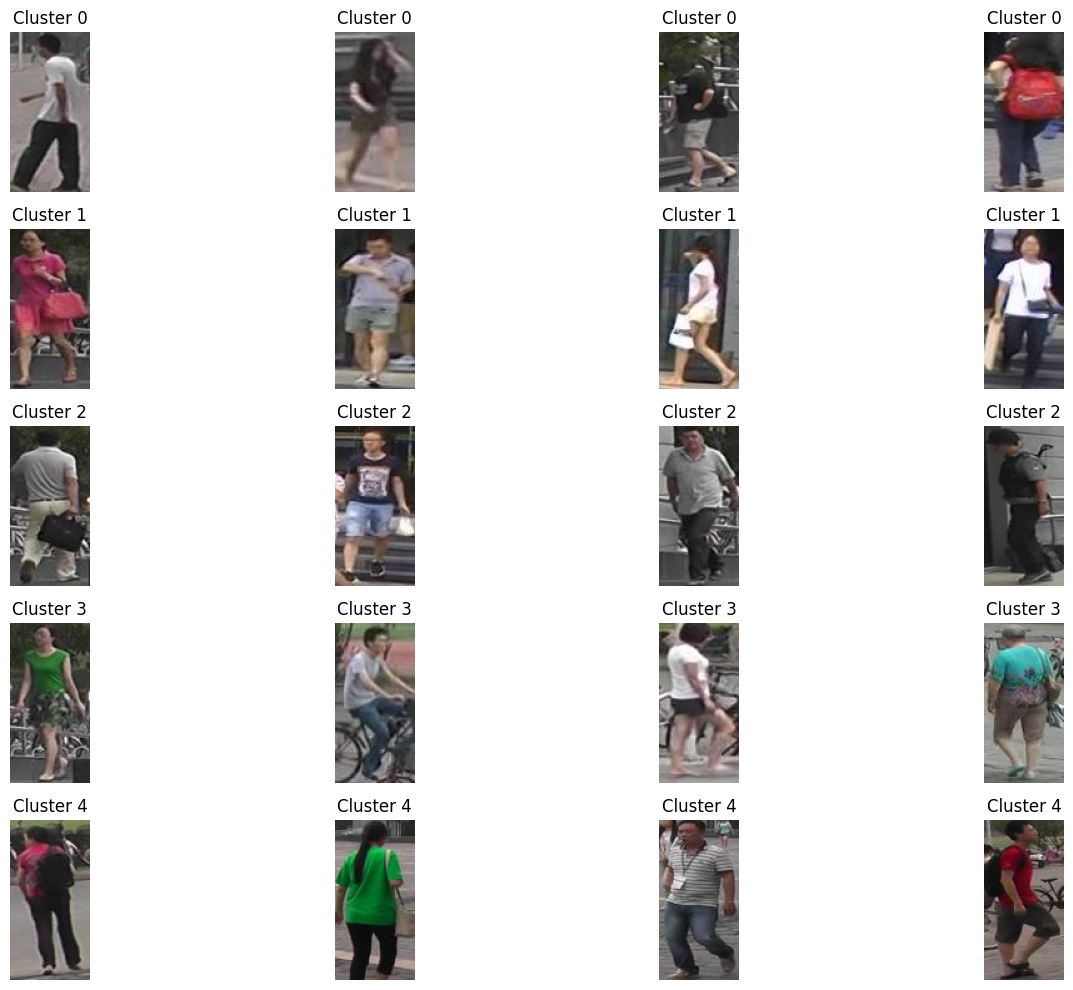

In [43]:
import matplotlib.pyplot as plt
import cv2
import random


def show_cluster_samples(image_paths, labels, num_clusters=10, samples_per_cluster=5):
    unique_clusters = list(set(labels))
    unique_clusters.sort()

    plt.figure(figsize=(15, num_clusters * 2))

    for cluster_idx, cluster in enumerate(unique_clusters[:num_clusters]):
        cluster_images = [img for img, label in zip(image_paths, labels) if label == cluster]
        sample_images = random.sample(cluster_images, min(samples_per_cluster, len(cluster_images)))

        for i, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(num_clusters, samples_per_cluster, cluster_idx * samples_per_cluster + i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Cluster {cluster}")

    plt.tight_layout()
    plt.show()


show_cluster_samples(image_paths, labels, num_clusters=5, samples_per_cluster=4)

In [44]:
!pip install faiss-cpu
import faiss

In [45]:
import faiss
import numpy as np

pca = PCA(n_components=100)
features_pca = pca.fit_transform(features)


features_array = np.array(features_pca, dtype='float32')


index = faiss.IndexFlatL2(features_array.shape[1])
index.add(features_array)

print(f"FAISS index created with {index.ntotal} images.")


FAISS index created with 5000 images.


In [49]:
def search_similar_images(query_image_path, top_k=5):
    query_feature = extract_features(query_image_path)
    query_feature_pca = pca.transform([query_feature])
    query_feature_pca = np.array(query_feature_pca, dtype='float32')


    distances, indices = index.search(query_feature_pca, top_k)


    retrieved_images = [image_paths[i] for i in indices[0]]

    return retrieved_images

query_img = "/content/drive/MyDrive/tango-cv-assessment-dataset/0002_c3s1_123058_00.jpg"
retrieved_imgs = search_similar_images(query_img, top_k=15)
print("Retrieved Images:", retrieved_imgs)

/content/drive/MyDrive/tango-cv-assessment-dataset/0002_c3s1_123058_00.jpg
step1
step2
Retrieved Images: ['/content/drive/MyDrive/tango-cv-assessment-dataset/0002_c3s1_000001_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0002_c5s1_123595_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/1091_c3s3_070494_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0158_c5s1_038201_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0477_c3s1_129058_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0233_c5s1_048301_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0683_c1s4_010056_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0244_c5s1_050926_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0233_c3s1_048076_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0075_c5s1_011176_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/1026_c1s6_038871_00.jpg', '/content/drive/MyDrive/tango-cv-ass

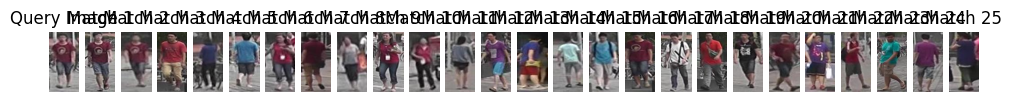

In [47]:
import matplotlib.pyplot as plt
import cv2

def show_retrieved_images(query_image_path, retrieved_images):
    plt.figure(figsize=(12, 6))


    query_img = cv2.imread(query_image_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(retrieved_images) + 1, 1)
    plt.imshow(query_img)
    plt.axis("off")
    plt.title("Query Image")


    for i, img_path in enumerate(retrieved_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(retrieved_images) + 1, i + 2)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Match {i+1}")

    plt.show()


show_retrieved_images(query_img, retrieved_imgs)


In [48]:
query_img = "/content/drive/MyDrive/tango-cv-assessment-dataset/0066_c3s1_012626_00.jpg"  # Replace with actual query image path
retrieved_imgs = search_similar_images(query_img, top_k=15)
print("Retrieved Images:", retrieved_imgs)

/content/drive/MyDrive/tango-cv-assessment-dataset/0066_c3s1_012626_00.jpg
step1
step2
Retrieved Images: ['/content/drive/MyDrive/tango-cv-assessment-dataset/0806_c3s2_105228_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0193_c3s1_059417_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0193_c3s1_059392_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0648_c3s2_034237_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0670_c3s2_044487_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/1067_c6s3_004992_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0006_c5s3_076087_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0440_c3s1_107092_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/1355_c3s3_040903_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/1213_c3s3_013553_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0688_c3s2_064303_00.jpg', '/content/drive/MyDrive/tango-cv-ass

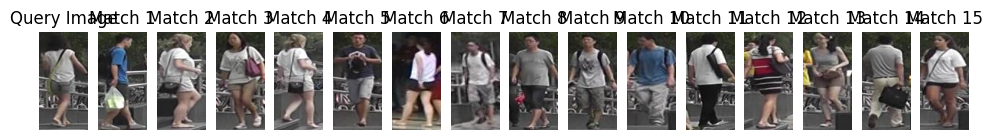

In [ ]:
def show_retrieved_images(query_image_path, retrieved_images):
    plt.figure(figsize=(12, 6))


    query_img = cv2.imread(query_image_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(retrieved_images) + 1, 1)
    plt.imshow(query_img)
    plt.axis("off")
    plt.title("Query Image")


    for i, img_path in enumerate(retrieved_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(retrieved_images) + 1, i + 2)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Match {i+1}")

    plt.show()


show_retrieved_images(query_img, retrieved_imgs)

In [ ]:
query_img = "/content/drive/MyDrive/tango-cv-assessment-dataset/0059_c1s1_011176_00.jpg"  # Replace with actual query image path
retrieved_imgs = search_similar_images(query_img, top_k=15)
print("Retrieved Images:", retrieved_imgs)

/content/drive/MyDrive/tango-cv-assessment-dataset/0059_c1s1_011176_00.jpg
step1
step2
Retrieved Images: ['/content/drive/MyDrive/tango-cv-assessment-dataset/0076_c1s1_011501_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0510_c1s6_033396_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0519_c5s1_143820_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0075_c5s1_011176_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0002_c5s1_123595_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0232_c3s1_047551_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0742_c2s2_063857_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0168_c1s1_030026_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0742_c5s2_067902_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0147_c1s1_035026_00.jpg', '/content/drive/MyDrive/tango-cv-assessment-dataset/0008_c1s1_000451_00.jpg', '/content/drive/MyDrive/tango-cv-ass

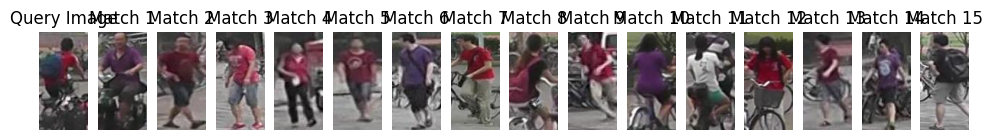

In [ ]:
import matplotlib.pyplot as plt
import cv2

def show_retrieved_images(query_image_path, retrieved_images):
    plt.figure(figsize=(12, 6))


    query_img = cv2.imread(query_image_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(retrieved_images) + 1, 1)
    plt.imshow(query_img)
    plt.axis("off")
    plt.title("Query Image")


    for i, img_path in enumerate(retrieved_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(retrieved_images) + 1, i + 2)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Match {i+1}")

    plt.show()


show_retrieved_images(query_img, retrieved_imgs)

**SECONDARY OBJECTIVES**

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ddxa0apm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ddxa0apm
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done


In [ ]:
import detectron2

In [ ]:
!pip install deepface torch torchvision detectron2 opencv-python numpy

In [ ]:
import cv2
import torch
import numpy as np
from deepface import DeepFace
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.model_zoo import model_zoo


cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)


In [ ]:
def extract_gender(image_path):
    try:
        result = DeepFace.analyze(image_path, actions=['gender'], enforce_detection=False)
        return result[0]['dominant_gender']
    except:
        return "Unknown"

In [ ]:
def extract_clothing_and_accessories(image_path):
    image = cv2.imread(image_path)
    outputs = predictor(image)


    classes = outputs["instances"].pred_classes.cpu().numpy()


    clothing_classes = {
        0: "Hat", 1: "Glasses", 2: "Bag", 5: "Shirt", 6: "Jacket", 14: "Tie"
    }

    detected_items = [clothing_classes[c] for c in classes if c in clothing_classes]


    detected_items = list(set(detected_items))

    return detected_items if detected_items else ["No accessories detected"]


In [ ]:
def get_person_attributes(image_path):
    gender = extract_gender(image_path)
    clothing_accessories = extract_clothing_and_accessories(image_path)

    print(f"Detected Gender: {gender}")
    print(f"Detected Clothing & Accessories: {', '.join(clothing_accessories)}")


query_img = "/content/drive/MyDrive/tango-cv-assessment-dataset/0004_c3s3_075694_00.jpg"
get_person_attributes(query_img)

Detected Gender: Unknown
Detected Clothing & Accessories: Hat


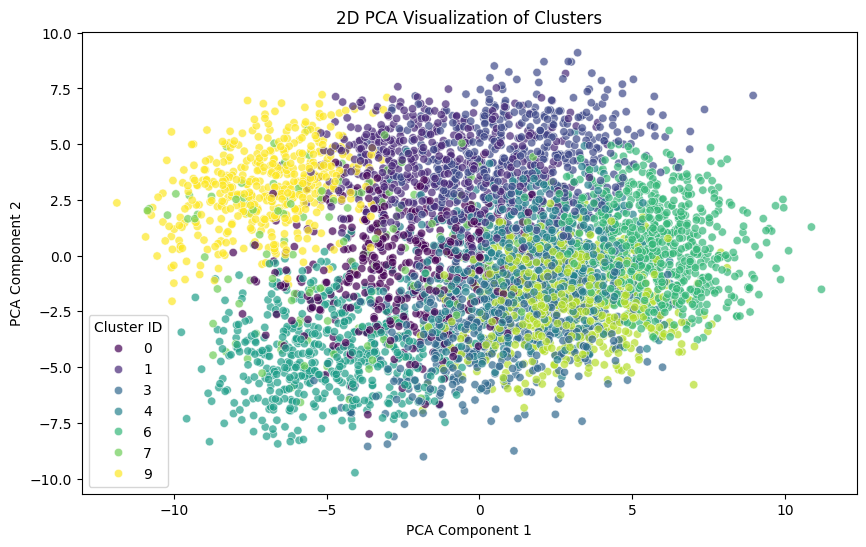

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


pca_2d = PCA(n_components=2).fit_transform(features_pca)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("2D PCA Visualization of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster ID")
plt.show()


In [56]:
features = np.array(features)


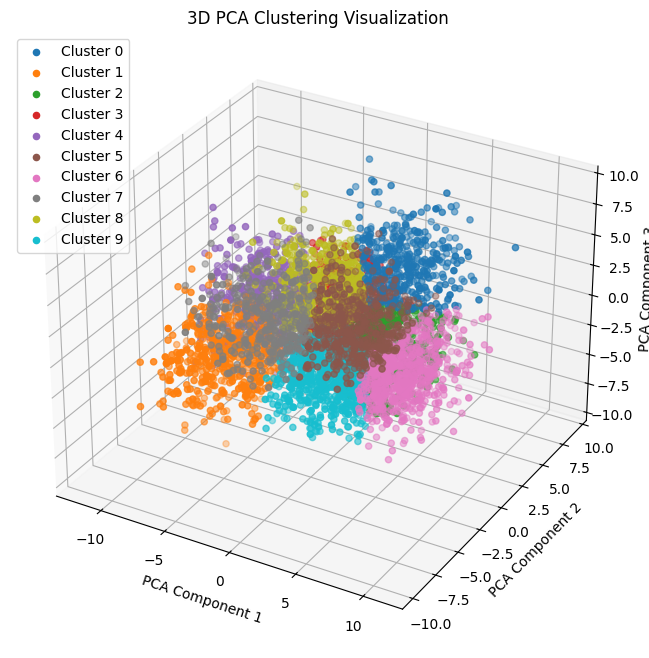

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plot_3d_clusters(features, num_clusters=10):
    """
    Generates a 3D PCA plot of image clusters.

    Parameters:
    features (numpy array): Extracted feature embeddings from ResNet-50.
    num_clusters (int): Number of clusters for KMeans.
    """
    if len(features) == 0:
        print("No features found. Check image paths or feature extraction.")
        return

    # Apply PCA to reduce features to 3D
    pca = PCA(n_components=3)
    features_3d = pca.fit_transform(features)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_3d)

    # Create 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = set(labels)
    for label in unique_labels:
        idxs = np.where(labels == label)
        ax.scatter(features_3d[idxs, 0], features_3d[idxs, 1], features_3d[idxs, 2], label=f'Cluster {label}')

    ax.set_title('3D PCA Clustering Visualization')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.legend()
    plt.show()

# Call function to plot 3D clusters
plot_3d_clusters(features, num_clusters=10)


In [71]:
pip install torch torchvision opencv-python numpy deepface

In [ ]:
!pip install facenet-pytorch
import cv2
import torch
import torchvision
from torchvision import transforms
import numpy as np
from deepface import DeepFace
from facenet_pytorch import MTCNN
from google.colab.patches import cv2_imshow  # For Google Colab

# Load Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set to evaluation mode

# Load Face Detector (MTCNN)
face_detector = MTCNN(keep_all=True)

# COCO class names
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
    'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Objects we want to detect
TARGET_CLASSES = ["person", "handbag", "backpack", "bicycle", "motorcycle", "car", "chair", "dining table"]

# Image preprocessing for Faster R-CNN
def transform_image(image):
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image)

# Gender classification function
def detect_gender(face_img):
    """
    Predicts gender (Male/Female) using DeepFace.

    Parameters:
    - face_img (numpy array): Cropped face image.

    Returns:
    - str: "Male" or "Female"
    """
    try:
        face_img = cv2.resize(face_img, (160, 160))  # Resize for DeepFace compatibility
        result = DeepFace.analyze(face_img, actions=['gender'], enforce_detection=False)
        gender = result[0]['dominant_gender']
        return gender.capitalize()  # Convert to "Male" or "Female"
    except:
        return "Unknown"

# Object detection function
def detect_objects(image_path):
    """
    Detect objects and gender from an image using Faster R-CNN + MTCNN.

    Parameters:
    - image_path (str): Path to the input image.

    Returns:
    - Processed image with detections drawn.
    """
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    original_image = image.copy()
    image_tensor = transform_image(image).unsqueeze(0)  # Convert image to tensor

    # Run Faster R-CNN model
    with torch.no_grad():
        predictions = model(image_tensor)[0]

    # Detect faces using MTCNN
    face_boxes, _ = face_detector.detect(original_image)

    for i in range(len(predictions['boxes'])):
        x1, y1, x2, y2 = map(int, predictions['boxes'][i].tolist())  # Bounding box
        confidence = float(predictions['scores'][i])  # Confidence score
        class_id = int(predictions['labels'][i])  # Class ID
        class_name = COCO_CLASSES[class_id]  # Object name

        # Only process relevant objects
        if class_name in TARGET_CLASSES and confidence > 0.5:
            color = (0, 255, 0)  # Green for general objects
            label = f"{class_name}: {confidence:.2f}"

            # If detecting a person, use MTCNN for better face detection
            if class_name == "person" and face_boxes is not None:
                for face in face_boxes:
                    fx1, fy1, fx2, fy2 = map(int, face)

                    # Ensure detected face is inside person bounding box
                    if fx1 >= x1 and fy1 >= y1 and fx2 <= x2 and fy2 <= y2:
                        face_crop = original_image[fy1:fy2, fx1:fx2]  # Extract face region
                        gender = detect_gender(face_crop)  # Predict gender
                        label = f"{gender} (Person): {confidence:.2f}"
                        color = (255, 0, 0)  # Blue for people
                        cv2.rectangle(image, (fx1, fy1), (fx2, fy2), (0, 0, 255), 2)  # Face box

            # Draw bounding box and label
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

# Run detection on an example image
image_path = "/content/drive/MyDrive/tango-cv-assessment-dataset/0001_c1s2_037091_00.jpg"  # Change this to your image path
output_image = detect_objects(image_path)

# Display the processed image (Google Colab)
if output_image is not None:
    cv2_imshow(output_image)  # Use in Colab


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2